# 0. Summary

### OASIS-1 Dataset: 
**It is a cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults.**

This set consists of a cross-sectional collection of `416 subjects` aged 18 to 96. For each subject, 3 or 4 individual `T1-weighted MRI` scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.

-------------------------------------------

### Current Notebook:
We are going to:
- Load `.npy` images from [Ninad Aithal](https://www.kaggle.com/datasets/ninadaithal/oasis-mri-dataset-npy)'s dataset which contains images for `347` subject and we will import the rest of dataset from his github repository.
- Extract corresponding label for each `MRI ID`.
- Select one MRI image for each unique `MRI ID`.
- Convert `.npy` to `.nii.gz` fromat.
- Perform `Skull Stripping` process using a pretrained deep learning model which is introduced in this paper: [Neural Pre-Processing](https://doi.org/10.48550/arXiv.2303.12148).
- Save the results.

#### Note that 201 rows in the cross-sectional dataset have missing value for `CDR` column.

# 1. Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn.image import math_img, load_img
import nilearn as nl
from nilearn import plotting as nplot
import os
import shutil
from glob import glob
import cv2
import nibabel as nib
from tqdm.notebook import tqdm

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 2. Tabular Dataset

In [2]:
cross_df = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

# 3. Image Dataset

In [3]:
# We are going to choose one MRI image per subject
pattern = "/kaggle/input/oasis-mri-dataset-npy/**/*.npy"
files = glob(pattern, recursive=True)
print(f"Number of MRI images: {len(files)}\nSample path:\n{files[0]}")

Number of MRI images: 1417
Sample path:
/kaggle/input/oasis-mri-dataset-npy/Non Demented/Non Demented/OAS1_0167_MR1_mpr-3.npy


In [4]:
def get_id(path):
    name = Path(path).parts[-1]
    mri_id = name.split('_MR')[0]
    return mri_id

files_dict = {}
for path in files:
    mri_id = get_id(path)
    files_dict.setdefault(mri_id, []).append(path)

print(f"Number of unique MRI IDs: {len(files_dict.keys())}")

Number of unique MRI IDs: 347


In [5]:
# We are going to choose one MRI image per subject
pattern = "/kaggle/input/oasis-mri-dataset-npy/**/*MR1_mpr-1.npy"
files = glob(pattern, recursive=True)
print(f"Number of MRI images: {len(files)}\nSample path:\n{files[0]}")

Number of MRI images: 346
Sample path:
/kaggle/input/oasis-mri-dataset-npy/Non Demented/Non Demented/OAS1_0047_MR1_mpr-1.npy


# 4. Labels

In [6]:
label_df = cross_df[['ID', 'CDR', 'M/F', 'Age']]
label_df.to_csv('labels.csv', index=False)
label_df.head()

,ID,CDR,M/F,Age
0,OAS1_0001_MR1,0.0,F,74
1,OAS1_0002_MR1,0.0,F,55
2,OAS1_0003_MR1,0.5,F,73
3,OAS1_0004_MR1,NaN,M,28
4,OAS1_0005_MR1,NaN,M,18


In [7]:
label_df.isna().sum()

ID       0
CDR    201
M/F      0
Age      0
dtype: int64

In [8]:
label_df['CDR'].value_counts()

CDR
0.0    135
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64

# 5. Convert `.npy` to `.nii.gz`

In [9]:
save_dir_org = '/kaggle/working/original'

def save_nii(path):
    mri_id = path.split('/')[-1].split('_m')[0]
    
    # Load the data from the .npy file
    data = np.load(path)

    # Create a NIfTI image from the data
    img = nib.Nifti1Image(data, affine=np.eye(4))
    
    if not os.path.exists(save_dir_org):
        os.makedirs(save_dir_org)
    
    file_path = os.path.join(save_dir_org, f"{mri_id}.nii.gz")
    # Save the NIfTI image to a .nii.gz file
    nib.save(img, file_path)

In [10]:
for path in tqdm(files):
    save_nii(path)

  0%|          | 0/346 [00:00<?, ?it/s]

### Importing the rest of the images for a [github](https://github.com/blackpearl006/OASIS_nifti_Part_11) repository

In [11]:
np.load(files[0]).dtype

dtype('float64')

In [12]:
! git clone https://github.com/blackpearl006/OASIS_nifti_Part_11.git

Cloning into 'OASIS_nifti_Part_11'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 179 (delta 1), reused 70 (delta 0), pack-reused 106
Receiving objects: 100% (179/179), 649.84 MiB | 38.89 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (136/136), done.


In [13]:
! git clone https://github.com/blackpearl006/OASIS_nifti_Part_12.git

Cloning into 'OASIS_nifti_Part_12'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 181 (delta 1), reused 81 (delta 0), pack-reused 97
Receiving objects: 100% (181/181), 775.16 MiB | 37.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (136/136), done.


In [14]:
pattern = "/kaggle/working/**/*_mpr-1_anon.nii.gz"
rest_files = glob(pattern, recursive=True)
print(f"Rest of the files: {len(rest_files)}")

# Copy into saving directory
for r_path in rest_files:
    shutil.copy(r_path, save_dir_org)
    
pattern = "/kaggle/working/original/*.gz"
nii_files = glob(pattern, recursive=True)
print(f"All of the files: {len(nii_files)}")

# Delete directories to free up storge space
for i in [11, 12]:
    shutil.rmtree(f"/kaggle/working/OASIS_nifti_Part_{i}")

Rest of the files: 70
All of the files: 416


In [15]:
def replace_nii(nii_arr, file_path):
    img = nib.Nifti1Image(nii_arr, affine=np.eye(4))
    nib.save(img, file_path)

In [16]:
def white_mask(path):
    img_arr = nib.load(path).get_fdata()
    img_arr = np.round(img_arr / img_arr.max() * 255).astype(np.uint8)
    
    mask = (img_arr < 150).astype(np.uint8)
    masked = img_arr * mask
    
    replace_nii(masked, path)

In [17]:
for nii_file in nii_files:
    white_mask(nii_file)

# 6. Skull Stripping

In [18]:
!git clone https://github.com/drsehid/skull_stripping.git

Cloning into 'skull_stripping'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 85 (delta 36), reused 50 (delta 11), pack-reused 0
Receiving objects: 100% (85/85), 2.59 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [19]:
! pip install torchio einops surfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.7/487.7 kB 19.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for surfa: filename=surfa-0.6.0-cp310-cp310-linux_x86_64.whl size=388923 sha256=ec65e3aa5189df5abd64f5ccda5813310ced72e6d68f6140f1a9eaac527f3e2a
  Stored in directory: /root/.cache/pip/wheels/13/24/62/f05e6682607cf8a5039e4a62d0bc00c5d48b859161e661ee5a
Successfully built surfa


In [20]:
import sys
import torch.nn as nn
import argparse
import surfa as sf
import scipy.ndimage
from skull_stripping.models.model import UNet

In [21]:
with torch.no_grad():
    model = UNet()
    model.to(device)
    model.eval()

In [22]:
version = '1'
print(f'Running Neural Pre-processing model version {version}')
cwd = os.getcwd()
modelfile = os.path.join(cwd,'/kaggle/input/ch-point', f'npp_v{version}.pth')
checkpoint = torch.load(modelfile, map_location=device)

model.load_state_dict(checkpoint)

Running Neural Pre-processing model version 1


<All keys matched successfully>

### Visualizing a Sample Outputs

In [23]:
idx = 35
file = nii_files[idx]

In [24]:
image = sf.load_volume(file)

# conform image and fit to shape with factors of 64
conformed = image.conform(voxsize=1.0, dtype='float32',shape=(256, 256, 256), method='nearest', orientation='LIA')

# normalize intensities
conformed = (conformed / 255).clip(0, 1)

# predict the surface distance transform
with torch.no_grad():
    input_tensor = torch.from_numpy(conformed.data[np.newaxis, np.newaxis]).to(device)
    output = model(input_tensor, 1)
    mni_norm = output[0].cpu().numpy().squeeze().astype(np.int16)
    norm = output[1].cpu().numpy().squeeze().astype(np.int16)
    scalar_field = output[2].cpu().numpy().squeeze().astype(np.int16)

# unconform the sdt and extract mask
mni_norm = conformed.new(mni_norm).resample_like(image, method='nearest', fill=0)
norm = conformed.new(norm).resample_like(image, method='nearest',fill=0)
scalar_field = conformed.new(scalar_field).resample_like(image, method='nearest',fill=0)

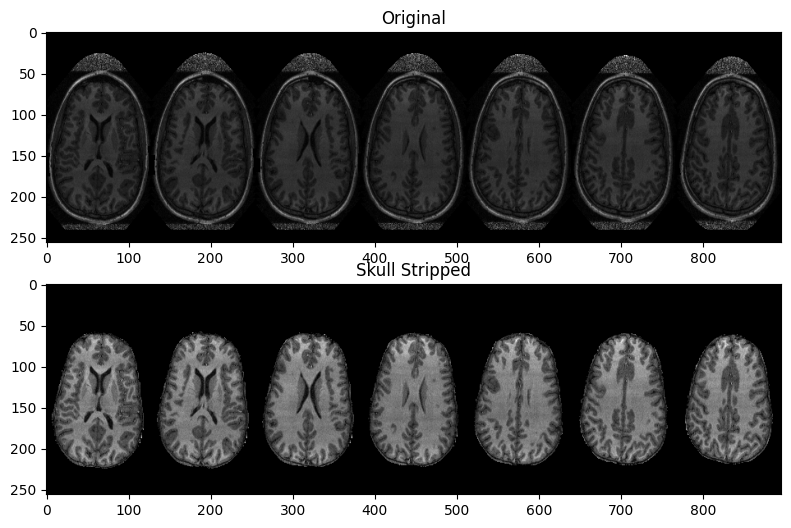

In [25]:
images = {}
sample_img = None

images['Original'] = nib.load(file).get_fdata()
images['Skull Stripped'] = (norm.data > 0) * images['Original']

f, axes = plt.subplots(2, 1, figsize=(12, 6))
start = 130
count = 7
interval = 3
prev_imgs = []
for i, (title, img) in enumerate(images.items()):
    img = np.hstack([np.rot90(img[:, :, start + j*interval]) for j in range(count)])
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title, )
        
plt.show()

### Saving Outputs for All Images

In [26]:
def skull_stripping(path):

    # loading image from a given path
    image = sf.load_volume(path)

    # conform image and fit to shape with factors of 64
    conformed = image.conform(voxsize=1.0, dtype='float32',shape=(256, 256, 256), method='nearest', orientation='LIA')
    
    # normalize intensities
    conformed = (conformed / 255).clip(0, 1)
    
    # predict the surface distance transform
    with torch.no_grad():
        input_tensor = torch.from_numpy(conformed.data[np.newaxis, np.newaxis]).to(device)
        output = model(input_tensor, 1)
        mni_norm = output[0].cpu().numpy().squeeze().astype(np.int16)
        norm = output[1].cpu().numpy().squeeze().astype(np.int16)
        scalar_field = output[2].cpu().numpy().squeeze().astype(np.int16)

    # unconform the sdt and extract mask
    mni_norm = conformed.new(mni_norm).resample_like(image,method='nearest', fill=0)
    norm = conformed.new(norm).resample_like(image, method='nearest',fill=0)
    scalar_field = conformed.new(scalar_field).resample_like(image, method='nearest',fill=0)

    return norm

In [27]:
save_dir_stripped = "/kaggle/working/skull-stripped"

if not os.path.exists(save_dir_stripped):
    os.makedirs(save_dir_stripped)

for path in tqdm(nii_files):
    file_name = Path(path).parts[-1]

    # Get Skull Stripped Image
    norm = skull_stripping(path)

    # Create a NIfTI image from the data
    image = nib.Nifti1Image(norm.data, affine=np.eye(4))

    # Save nii file
    file_path = os.path.join(save_dir_stripped, file_name)

    nib.save(image, file_path)

  0%|          | 0/416 [00:00<?, ?it/s]

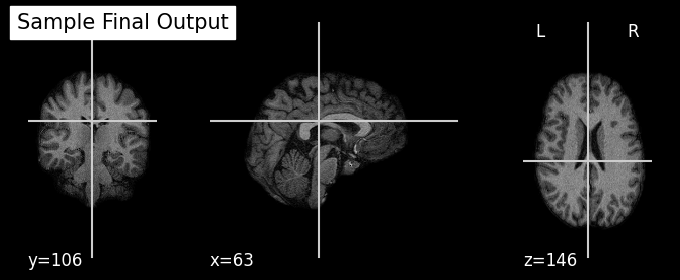

In [28]:
stripped_files = glob('/kaggle/working/skull-stripped/*.gz', recursive=True)
nplot.plot_anat(stripped_files[10], title="Sample Final Output")

In [29]:
print(f"{len(stripped_files)} images from OASIS1 dataset are skull stripped.")

416 images from OASIS1 dataset are skull stripped.


# Zipping

In [30]:
# create a zip archive
shutil.make_archive('./stripped', 'zip', save_dir_stripped)
shutil.rmtree(save_dir_stripped)

# create a zip archive
shutil.make_archive('./original', 'zip', save_dir_org)
shutil.rmtree(save_dir_org)

shutil.rmtree("/kaggle/working/skull_stripping")